In [20]:
import pandas as pd
import numpy as np
from datetime import timedelta
from dateutil.easter import easter
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pandas.tseries.frequencies import to_offset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

In [10]:
df = pd.read_csv("cocoa.csv", parse_dates=["Date"])

df = df.sort_values("Date").reset_index(drop=True)

df = df.drop_duplicates()

df = df.drop(columns=["YEAR", "DOY","Unnamed: 0"], errors="ignore")

df["Price_NY"] = df["Price_NY"].replace(",", "", regex=True).astype(float)
df.loc[(df["Price_NY"] <= 0) | (df["Price_NY"] > 10000), "Price_NY"] = np.nan

df["Mid.Rate"] = df["Mid.Rate"].replace(",", "", regex=True).astype(float)
df.loc[(df["Mid.Rate"] <= 0) | (df["Mid.Rate"] > 1000), "Mid.Rate"] = np.nan

for col in ["T2M", "T2M_MAX", "T2M_MIN", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df.loc[df[col] < 0, col] = np.nan

df = df.fillna(method="ffill")

df["MONTH"] = df["Date"].dt.month
df["WEEKDAY"] = df["Date"].dt.weekday + 1

df["logprice"] = np.log(df["Price_NY"])

df_clean = df.dropna()

years = df["Date"].dt.year.unique()

holiday_core_dates = []

for y in years:
    holiday_core_dates.append(pd.Timestamp(f"{y}-12-25")) 
    holiday_core_dates.append(pd.Timestamp(f"{y}-10-31"))  
    holiday_core_dates.append(easter(int(y)))          

holiday_extended_dates = set()
for d in holiday_core_dates:
    for offset in range(-5, 6): 
        holiday_extended_dates.add(d + timedelta(days=offset))

holiday_extended_dates = pd.to_datetime(list(holiday_extended_dates))

df["Is_Holiday"] = df["Date"].isin(holiday_extended_dates).astype(int)

df_clean = df.dropna()

trend_df = pd.read_csv("multiTimeline.csv", skiprows=2)

trend_df.columns = ["Month", "Cocoa_Trend"]

trend_df["Month"] = pd.to_datetime(trend_df["Month"], format="%Y-%m")

df["Month"] = df["Date"].dt.to_period("M").dt.to_timestamp()
df = df.merge(trend_df, on="Month", how="left")

df = df.drop(columns=["Month"], errors="ignore")

df = df.sort_values("Date")

df["Month"] = df["Date"].dt.to_period("M").dt.to_timestamp()

monthly_return = df.groupby("Month").apply(
    lambda x: np.log(x["Price_NY"].iloc[-1] / x["Price_NY"].iloc[0])
).reset_index(name="log_return_rate")

monthly_avg = df.groupby("Month").agg({
    "Mid.Rate": "mean",
    "T2M": "mean",
    "T2M_MAX": "mean",
    "T2M_MIN": "mean",
    "PRECTOTCORR": "mean",
    "ALLSKY_SFC_SW_DWN": "mean",
    "Cocoa_Trend": "mean",           
    "logprice": "mean",
    "Price_NY": "mean"  
}).reset_index()

monthly_avg = pd.merge(monthly_avg, monthly_return, on="Month", how="left")

holiday_monthly = df.groupby("Month")["Is_Holiday"].max().reset_index()
 
monthly_data = pd.merge(monthly_avg, holiday_monthly, on="Month", how="left")

monthly_data["YEAR"] = monthly_data["Month"].dt.year
monthly_data["MONTH_NUM"] = monthly_data["Month"].dt.month

/var/folders/q8/kyc6m7p53rg0v4csq3bs5pn40000gn/T/ipykernel_2995/1057829242.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")
/var/folders/q8/kyc6m7p53rg0v4csq3bs5pn40000gn/T/ipykernel_2995/1057829242.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_return = df.groupby("Month").apply(


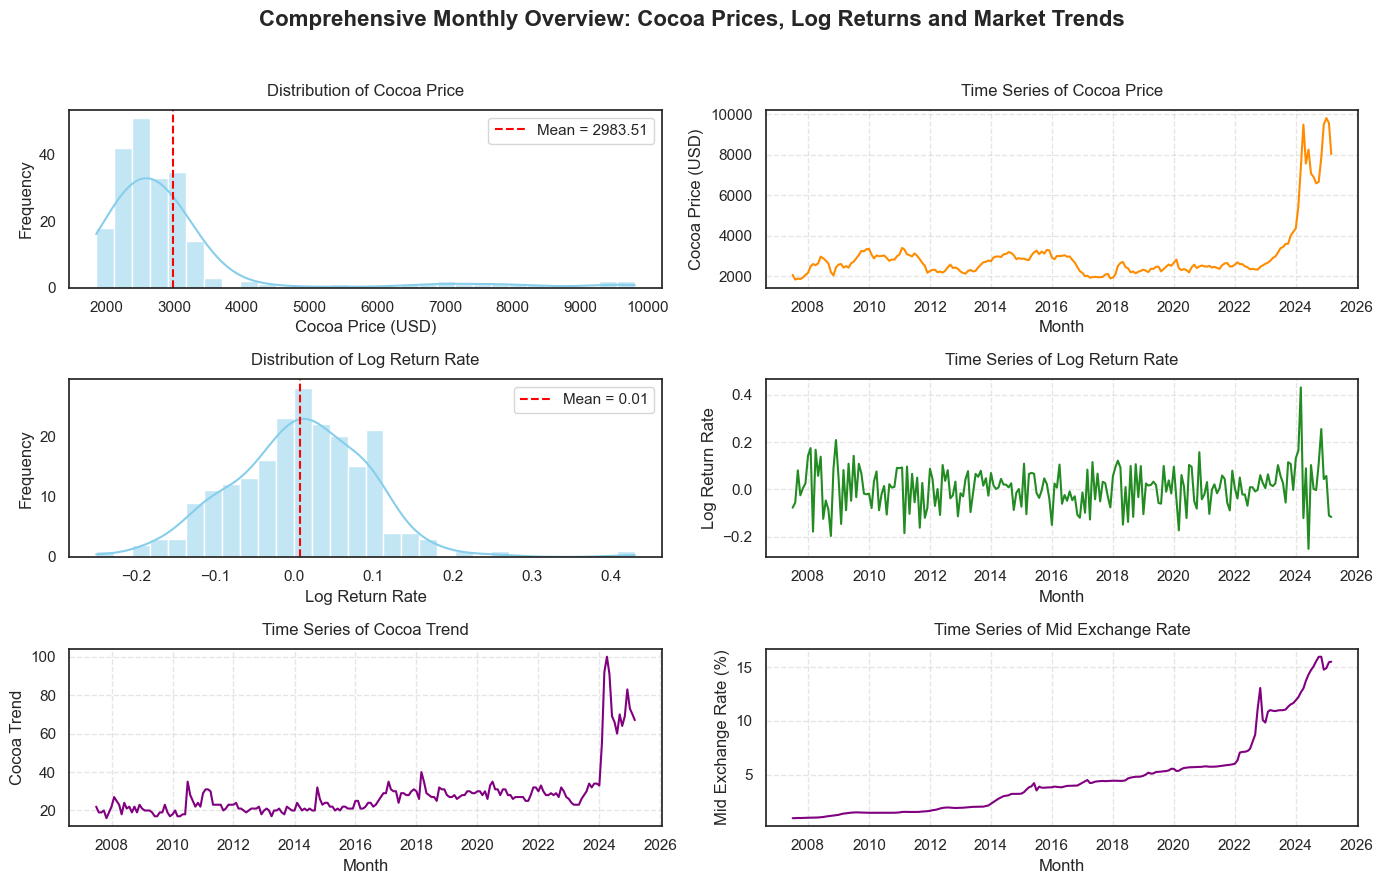

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 使用 ggplot 风格
plt.style.use("ggplot")
sns.set_theme(style="white")

# 假设 monthly_data 已经构建好，包含以下字段：
# "Month", "Price_NY", "log_return_rate", "Cocoa_Trend", "Mid.Rate"

# 定义变量列表及对应信息
special_vars = [
    {"col": "Price_NY", "label": "Cocoa Price", "unit": "USD", "line_color": "darkorange"},
    {"col": "log_return_rate", "label": "Log Return Rate", "unit": "", "line_color": "forestgreen"}
]

other_vars = [
    {"col": "Cocoa_Trend", "label": "Cocoa Trend", "unit": ""},
    {"col": "Mid.Rate", "label": "Mid Exchange Rate", "unit": "%"}
]

# 总共行数：前两行显示 special_vars（分布图+时序图），其它变量每行放两个时序图
import math
n_other_rows = math.ceil(len(other_vars) / 2)
total_rows = 2 + n_other_rows

fig, axes = plt.subplots(total_rows, 2, figsize=(14, 3 * total_rows))
fig.suptitle("Comprehensive Monthly Overview: Cocoa Prices, Log Returns and Market Trends", 
             fontsize=16, weight="bold", y=0.98)

# 绘制 special_vars：每个变量占用一整行（左：分布图；右：时序图）
for i, var in enumerate(special_vars):
    col_name = var["col"]
    label = var["label"]
    unit = var["unit"]
    line_color = var["line_color"]
    xlabel = f"{label} ({unit})" if unit else label

    # 左侧：分布图
    ax_dist = axes[i, 0]
    sns.histplot(data=monthly_data, x=col_name, bins=30, kde=True, color="skyblue", ax=ax_dist)
    mean_val = monthly_data[col_name].mean()
    ax_dist.axvline(mean_val, color="red", linestyle="--", label=f"Mean = {mean_val:.2f}")
    ax_dist.set_title(f"Distribution of {label}", fontsize=12, pad=10)
    ax_dist.set_xlabel(xlabel)
    ax_dist.set_ylabel("Frequency")
    ax_dist.legend()

    # 右侧：时间序列图
    ax_ts = axes[i, 1]
    ax_ts.plot(monthly_data["Month"], monthly_data[col_name], color=line_color, linewidth=1.5)
    ax_ts.set_title(f"Time Series of {label}", fontsize=12, pad=10)
    ax_ts.set_xlabel("Month")
    ax_ts.set_ylabel(xlabel)
    ax_ts.grid(True, linestyle="--", alpha=0.5)

# 绘制 other_vars：仅时间序列图，从第 3 行开始，每行显示 2 个变量
start_row = 2
for idx, var in enumerate(other_vars):
    row = start_row + idx // 2
    col_idx = idx % 2
    col_name = var["col"]
    label = var["label"]
    unit = var["unit"]
    xlabel = f"{label} ({unit})" if unit else label

    ax_ts = axes[row, col_idx]
    ax_ts.plot(monthly_data["Month"], monthly_data[col_name], color="purple", linewidth=1.5)
    ax_ts.set_title(f"Time Series of {label}", fontsize=12, pad=10)
    ax_ts.set_xlabel("Month")
    ax_ts.set_ylabel(xlabel)
    ax_ts.grid(True, linestyle="--", alpha=0.5)

# 如果最后一行多余子图，则隐藏空白的子图
total_subplots = total_rows * 2
used_subplots = 2 * len(special_vars) + len(other_vars)
if used_subplots < total_subplots:
    for i in range(used_subplots, total_subplots):
        fig.get_axes()[i].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


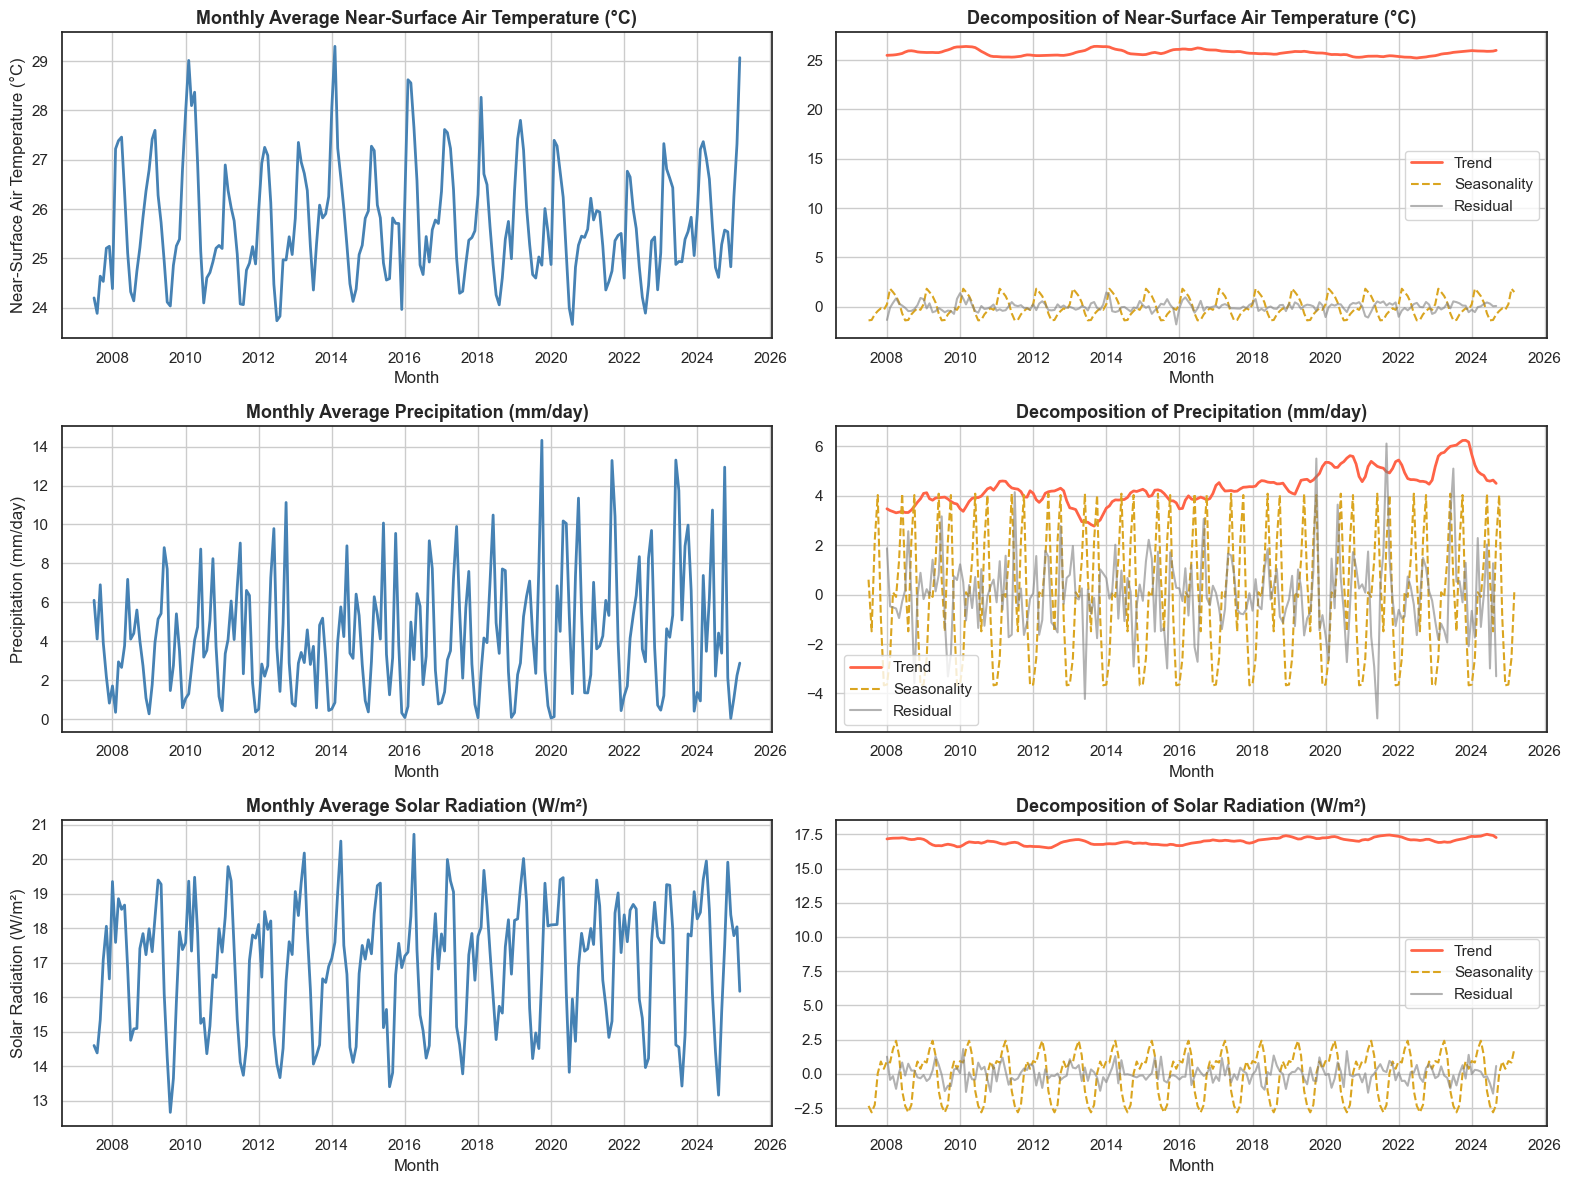

In [17]:

# 确保时间设置正确
monthly_data_ts = monthly_data.set_index("Month")

# 要处理的变量和标签
variables = {
    "T2M": "Near-Surface Air Temperature (°C)",
    "PRECTOTCORR": "Precipitation (mm/day)",
    "ALLSKY_SFC_SW_DWN": "Solar Radiation (W/m²)"
}

# 创建大图（3行2列）
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4)

for i, (var, label) in enumerate(variables.items()):
    # 左图：原始时间序列
    axes[i, 0].plot(monthly_data["Month"], monthly_data[var], color="steelblue", linewidth=2)
    axes[i, 0].set_title(f"Monthly Average {label}", fontsize=13, weight='bold')
    axes[i, 0].set_xlabel("Month")
    axes[i, 0].set_ylabel(label)
    axes[i, 0].grid(True)

    # 右图：分解图（只画 trend + seasonal + residual）
    result = seasonal_decompose(monthly_data_ts[var], model="additive", period=12)

    # Decomposition subplot manually
    axes[i, 1].plot(result.trend, label="Trend", color="tomato", linewidth=2)
    axes[i, 1].plot(result.seasonal, label="Seasonality", color="goldenrod", linestyle="--")
    axes[i, 1].plot(result.resid, label="Residual", color="gray", alpha=0.6)
    axes[i, 1].set_title(f"Decomposition of {label}", fontsize=13, weight='bold')
    axes[i, 1].set_xlabel("Month")
    axes[i, 1].legend()
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()


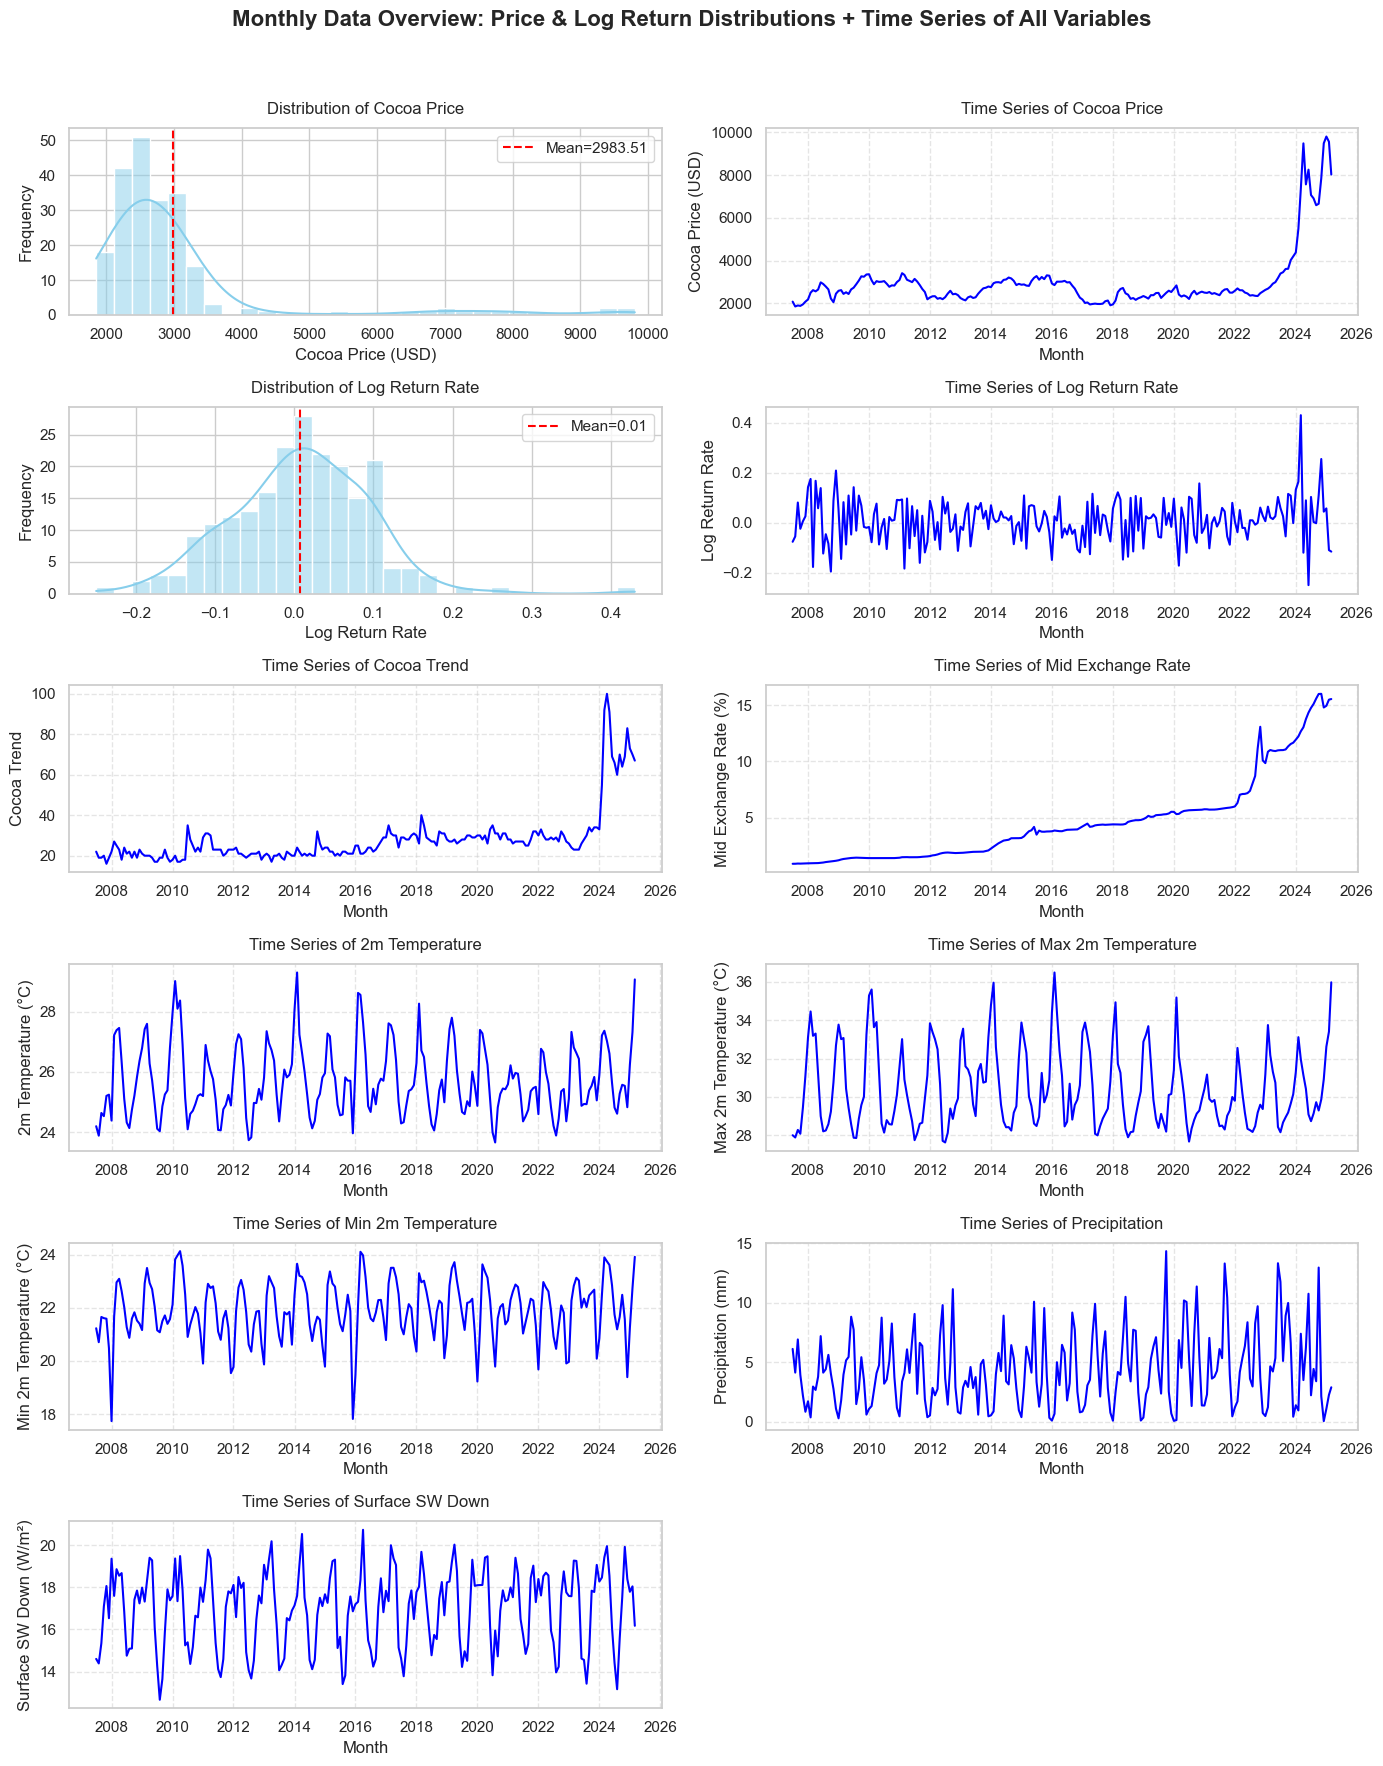

In [13]:
sns.set_theme(style="whitegrid")

# ---------------------------
# 1) 定义需要绘图的变量
# ---------------------------
# special_vars: 需要“分布图+时间序列”的变量
special_vars = [
    {"col": "Price_NY", "label": "Cocoa Price", "unit": "USD"},
    {"col": "log_return_rate", "label": "Log Return Rate", "unit": ""}
]

# other_vars: 只需要“时间序列”的变量
other_vars = [
    {"col": "Cocoa_Trend",       "label": "Cocoa Trend",          "unit": ""},
    {"col": "Mid.Rate",          "label": "Mid Exchange Rate",    "unit": "%"},
    {"col": "T2M",               "label": "2m Temperature",       "unit": "°C"},
    {"col": "T2M_MAX",           "label": "Max 2m Temperature",   "unit": "°C"},
    {"col": "T2M_MIN",           "label": "Min 2m Temperature",   "unit": "°C"},
    {"col": "PRECTOTCORR",       "label": "Precipitation",        "unit": "mm"},
    {"col": "ALLSKY_SFC_SW_DWN", "label": "Surface SW Down",      "unit": "W/m²"}
]

# ---------------------------
# 2) 创建 6 行 × 2 列的画布
# ---------------------------
fig, axes = plt.subplots(6, 2, figsize=(14, 18))
fig.suptitle(
    "Monthly Data Overview: Price & Log Return Distributions + Time Series of All Variables",
    fontsize=16, weight="bold", y=0.98
)

# ---------------------------
# 3) 绘制前两行：Price + Log Return
#    - 每个变量占用一整行，左列分布图、右列时序图
# ---------------------------
for i, var_dict in enumerate(special_vars):
    row = i  # 第 0 行 or 第 1 行
    col_name = var_dict["col"]
    label = var_dict["label"]
    unit = var_dict["unit"]
    xlabel = f"{label} ({unit})" if unit else label

    # 左侧：分布图
    ax_dist = axes[row, 0]
    sns.histplot(
        data=monthly_data,
        x=col_name,
        bins=30,
        kde=True,
        color="skyblue",
        ax=ax_dist
    )
    mean_val = monthly_data[col_name].mean()
    ax_dist.axvline(mean_val, color="red", linestyle="--", label=f"Mean={mean_val:.2f}")
    ax_dist.set_title(f"Distribution of {label}", fontsize=12, pad=10)
    ax_dist.set_xlabel(xlabel)
    ax_dist.set_ylabel("Frequency")
    ax_dist.legend()

    # 右侧：时间序列图
    ax_ts = axes[row, 1]
    ax_ts.plot(monthly_data["Month"], monthly_data[col_name], color="blue")
    ax_ts.set_title(f"Time Series of {label}", fontsize=12, pad=10)
    ax_ts.set_xlabel("Month")
    ax_ts.set_ylabel(xlabel)
    ax_ts.grid(True, linestyle="--", alpha=0.5)

# ---------------------------
# 4) 绘制剩余 7 个变量：只做时间序列图
#    放在第 2~... 行，每行 2 个子图
# ---------------------------
start_row = 2  # 从第 2 行开始摆放
for idx, var_dict in enumerate(other_vars):
    row = start_row + idx // 2  # 两个变量一行
    col = idx % 2
    col_name = var_dict["col"]
    label = var_dict["label"]
    unit = var_dict["unit"]
    xlabel = f"{label} ({unit})" if unit else label
    
    ax_ts = axes[row, col]
    ax_ts.plot(monthly_data["Month"], monthly_data[col_name], color="blue")
    ax_ts.set_title(f"Time Series of {label}", fontsize=12, pad=10)
    ax_ts.set_xlabel("Month")
    ax_ts.set_ylabel(xlabel)
    ax_ts.grid(True, linestyle="--", alpha=0.5)

# ---------------------------
# 5) 隐藏可能的空子图（如果有剩余）
# ---------------------------
# 在本例中，6x2=12 张子图，而我们只用到了 2(Price+LogReturn)*2 + 7=11 个。
# 剩下 1 个空子图可以手动隐藏：
if len(other_vars) % 2 != 0:
    # 说明 odd number => 最后一行右列是空
    axes[5, 1].set_visible(False)  # 隐藏它

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-package

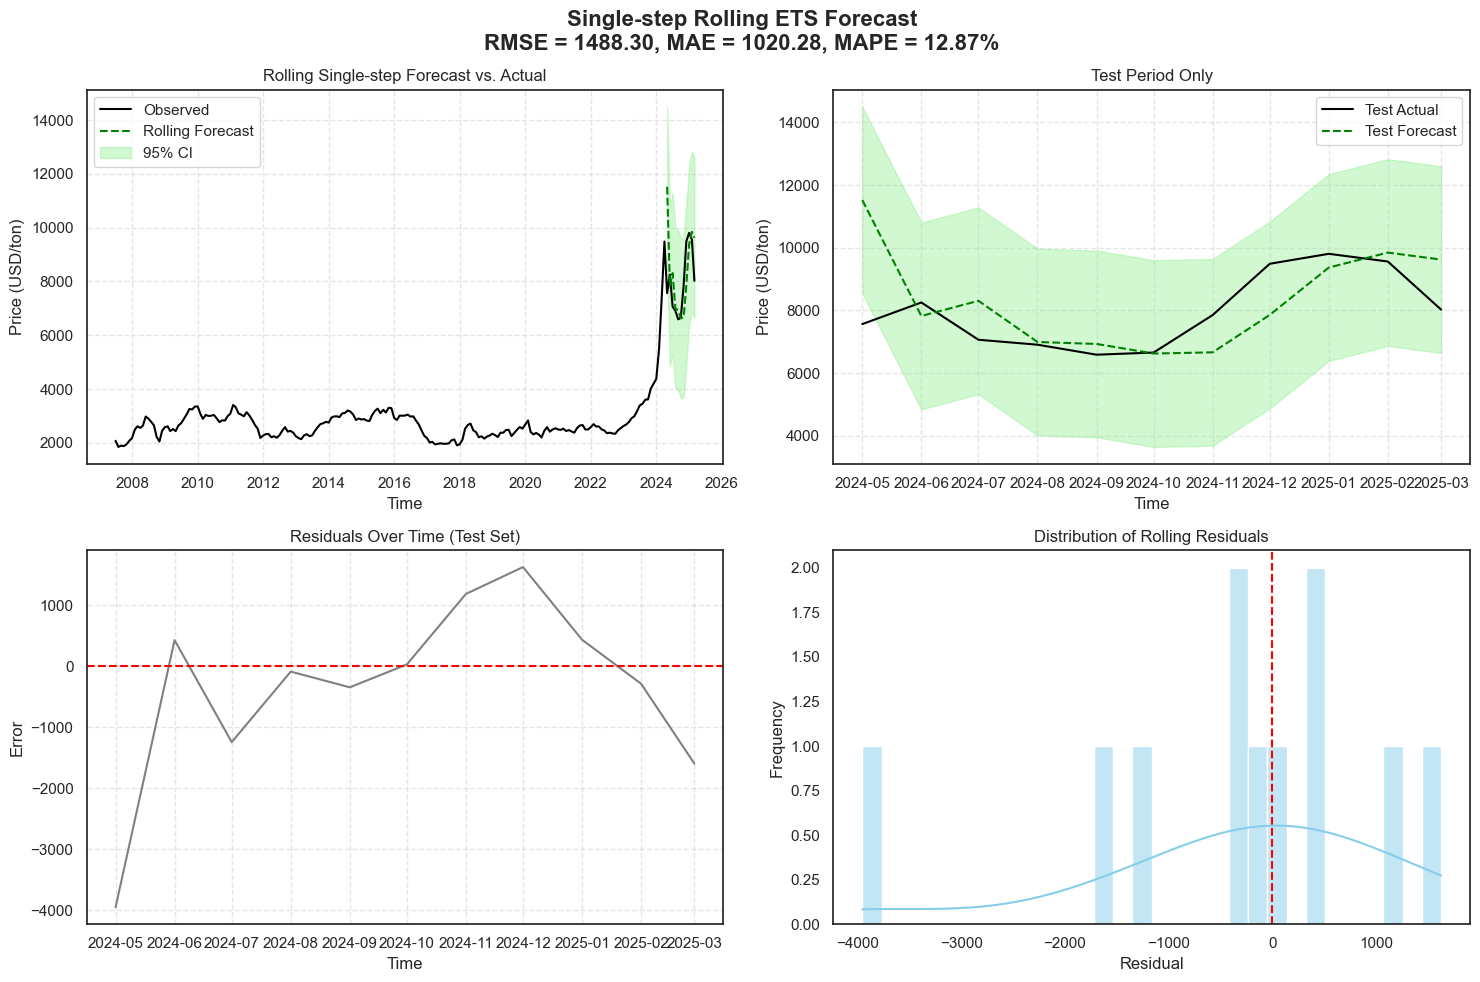

In [21]:
# ------------------------------------------------
# 1. Prepare Data
# ------------------------------------------------
# Example assumes you have a monthly dataframe `monthly_data` with columns ['Month', 'Price_NY'],
# and 'Month' is a datetime column. We create a time-indexed series:
monthly_data_ts = monthly_data.set_index("Month")
price_series = monthly_data_ts["Price_NY"]

# Train/Test split (80% train, 20% test for demonstration)
n = len(price_series)
train_size = int(n * 0.95)

train_series_initial = price_series.iloc[:train_size]
test_series = price_series.iloc[train_size:]

# We'll store rolling forecasts here
rolling_forecasts = {}
rolling_residuals = {}

# ------------------------------------------------
# 2. Rolling (Single-Step) Forecast
# ------------------------------------------------
for test_date in test_series.index:
    # Training data: all data up to (but NOT including) `test_date`
    # Since .loc is inclusive, we slice up to test_date, then drop the last observation:
    current_train_data = price_series.loc[:test_date].iloc[:-1]
    
    # Fit the ETS model on current training set
    ets_model = ETSModel(
        current_train_data,
        error="add",
        trend="add",
        seasonal="add",
        seasonal_periods=12
    )
    ets_result = ets_model.fit()
    
    # Single-step forecast (steps=1)
    forecast_value = ets_result.forecast(steps=1).iloc[0]
    
    # Store the forecast in a dictionary (keyed by the test_date)
    rolling_forecasts[test_date] = forecast_value
    
    # Compute the residual for convenience (actual - forecast)
    actual_value = price_series.loc[test_date]
    rolling_residuals[test_date] = actual_value - forecast_value

# Convert the stored forecasts & residuals to Series
rolling_forecast_series = pd.Series(rolling_forecasts)
rolling_residual_series = pd.Series(rolling_residuals)

# ------------------------------------------------
# 3. Evaluation Metrics
# ------------------------------------------------
# Align forecast_series with the actual test_series
common_index = test_series.index.intersection(rolling_forecast_series.index)
true_test_values = test_series.loc[common_index]
pred_test_values = rolling_forecast_series.loc[common_index]

rmse = np.sqrt(mean_squared_error(true_test_values, pred_test_values))
mae = mean_absolute_error(true_test_values, pred_test_values)
mape = mean_absolute_percentage_error(true_test_values, pred_test_values) * 100

# ------------------------------------------------
# 4. (Optional) Confidence Interval
# ------------------------------------------------
# For a strictly correct rolling confidence interval, you'd compute the residual std
# from each refitted model's training set. Here, for simplicity, we can approximate
# by using the overall rolling residuals' std:
resid_std = rolling_residual_series.std()
z = 1.96
ci_upper = pred_test_values + z * resid_std
ci_lower = pred_test_values - z * resid_std

# ------------------------------------------------
# 5. Plotting (2x2 Diagnostic Panel)
# ------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Title with metrics
fig.suptitle(
    f"Single-step Rolling ETS Forecast\n"
    f"RMSE = {rmse:.2f}, MAE = {mae:.2f}, MAPE = {mape:.2f}%",
    fontsize=16, weight="bold"
)

# (1) Full Series with Rolling Forecast
axes[0, 0].plot(price_series, label="Observed", color="black")
axes[0, 0].plot(pred_test_values, label="Rolling Forecast", color="green", linestyle="--")
axes[0, 0].fill_between(pred_test_values.index, ci_lower, ci_upper, 
                        color="lightgreen", alpha=0.4, label="95% CI")
axes[0, 0].set_title("Rolling Single-step Forecast vs. Actual", fontsize=12)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Price (USD/ton)")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

# (2) Zoom in on Test Period
axes[0, 1].plot(true_test_values, label="Test Actual", color="black")
axes[0, 1].plot(pred_test_values, label="Test Forecast", color="green", linestyle="--")
axes[0, 1].fill_between(pred_test_values.index, ci_lower, ci_upper, 
                        color="lightgreen", alpha=0.4)
axes[0, 1].set_title("Test Period Only", fontsize=12)
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Price (USD/ton)")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

# (3) Residuals Over Time
axes[1, 0].plot(rolling_residual_series, label="Rolling Residuals", color="gray")
axes[1, 0].axhline(0, color="red", linestyle="--")
axes[1, 0].set_title("Residuals Over Time (Test Set)", fontsize=12)
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Error")
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

# (4) Distribution of Residuals
sns.histplot(rolling_residual_series, bins=30, kde=True, color="skyblue", ax=axes[1, 1])
axes[1, 1].axvline(0, color="red", linestyle="--")
axes[1, 1].set_title("Distribution of Rolling Residuals", fontsize=12)
axes[1, 1].set_xlabel("Residual")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


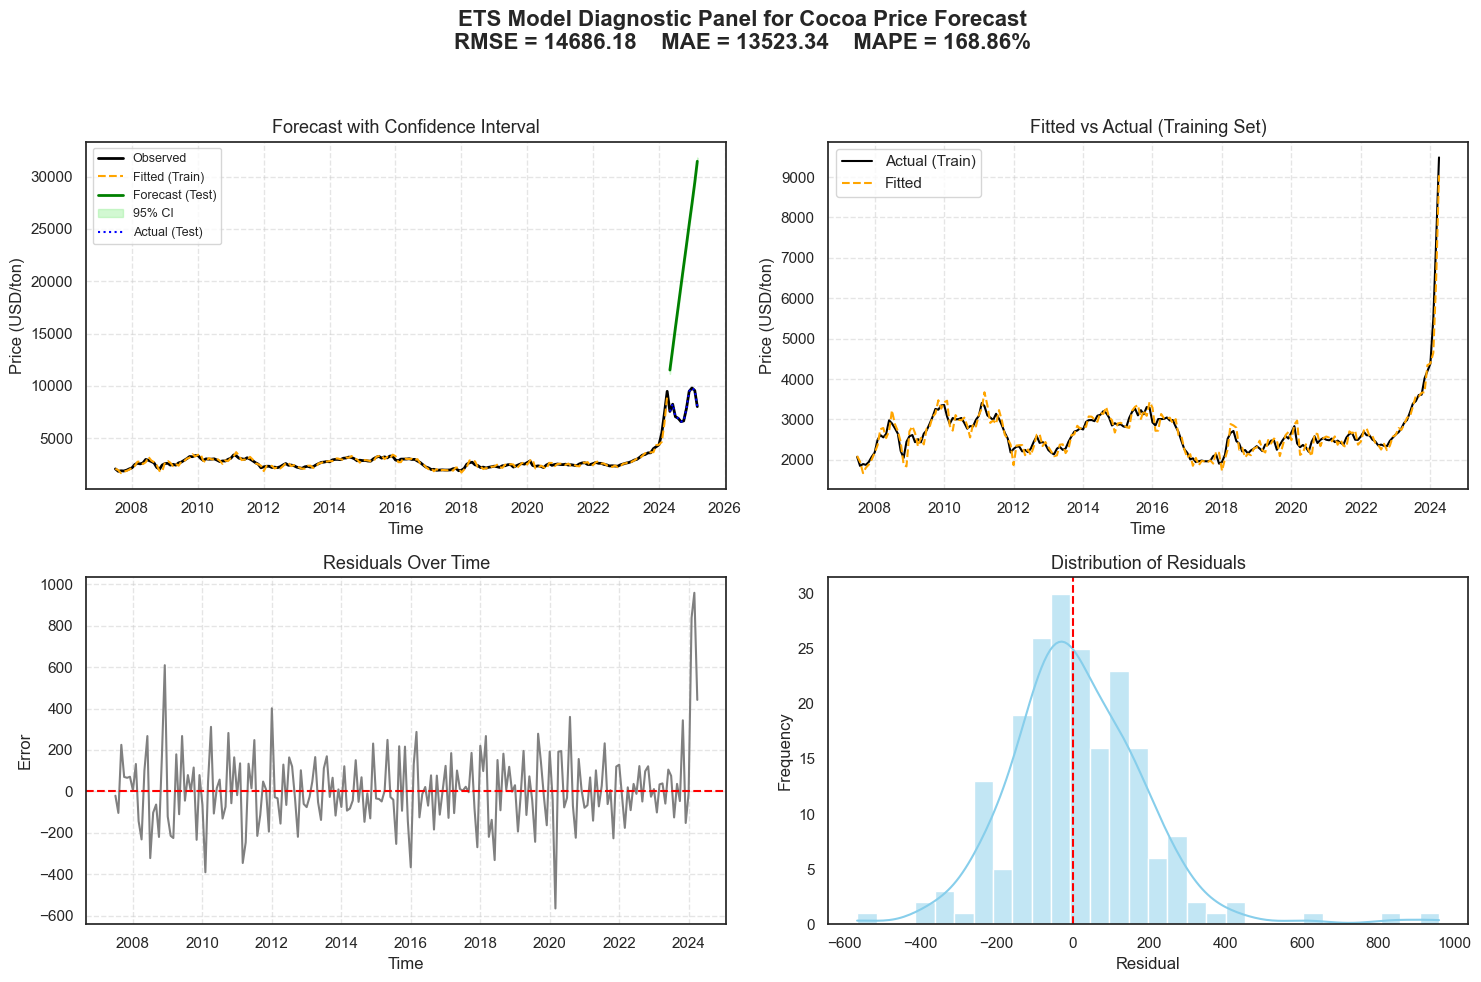

In [22]:
monthly_data_ts = monthly_data.set_index("Month")
price_series = monthly_data_ts["Price_NY"]

n = len(price_series)
train_size = int(n * 0.95)

train_series = price_series.iloc[:train_size]
test_series = price_series.iloc[train_size:]
test_steps = len(test_series)

ets_model = ETSModel(
    train_series,
    error="add",
    trend="add",
    seasonal="add",
    seasonal_periods=12
)
ets_result = ets_model.fit()

forecast_values = ets_result.forecast(steps=test_steps)
forecast_index = test_series.index

resid_std = ets_result.resid.std()

z = 1.96

forecast_mean = ets_result.forecast(steps=test_steps)

ci_upper = forecast_mean + z * resid_std
ci_lower = forecast_mean - z * resid_std

residuals = ets_result.resid

rmse = root_mean_squared_error(test_series, forecast_values)
mae = mean_absolute_error(test_series, forecast_values)
mape = mean_absolute_percentage_error(test_series, forecast_values)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# === Title with Metrics ===
fig.suptitle(
    f"ETS Model Diagnostic Panel for Cocoa Price Forecast\n"
    f"RMSE = {rmse:.2f}    MAE = {mae:.2f}    MAPE = {mape*100:.2f}%",
    fontsize=16, weight="bold"
)

# === Forecast Panel ===
axes[0, 0].plot(price_series, label="Observed", color="black", linewidth=2)
axes[0, 0].plot(ets_result.fittedvalues, label="Fitted (Train)", color="orange", linestyle="--")
axes[0, 0].plot(forecast_index, forecast_mean, label="Forecast (Test)", color="green", linewidth=2)
axes[0, 0].fill_between(forecast_index, ci_lower, ci_upper, color="lightgreen", alpha=0.4, label="95% CI")
axes[0, 0].plot(test_series, label="Actual (Test)", color="blue", linestyle="dotted")
axes[0, 0].set_title("Forecast with Confidence Interval", fontsize=13)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Price (USD/ton)")
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

# === Fitted vs Actual ===
axes[0, 1].plot(train_series, label="Actual (Train)", color="black")
axes[0, 1].plot(ets_result.fittedvalues, label="Fitted", color="orange", linestyle="--")
axes[0, 1].set_title("Fitted vs Actual (Training Set)", fontsize=13)
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Price (USD/ton)")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

# === Residuals ===
axes[1, 0].plot(residuals, label="Residuals", color="gray")
axes[1, 0].axhline(0, color="red", linestyle="--")
axes[1, 0].set_title("Residuals Over Time", fontsize=13)
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Error")
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

# === Histogram ===
sns.histplot(residuals, bins=30, kde=True, color="skyblue", ax=axes[1, 1])
axes[1, 1].axvline(0, color="red", linestyle="--")
axes[1, 1].set_title("Distribution of Residuals", fontsize=13)
axes[1, 1].set_xlabel("Residual")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


In [23]:
adf_result_orig = adfuller(price_series)
print("🔍 ADF Test on Original Series")
print(f"ADF Statistic: {adf_result_orig[0]:.4f}")
print(f"p-value: {adf_result_orig[1]:.4f}")

🔍 ADF Test on Original Series
ADF Statistic: -0.0851
p-value: 0.9509


In [24]:
first_diff = price_series.diff().dropna()

adf_result_diff = adfuller(first_diff)
print("\n🔍 ADF Test on First Difference")
print(f"ADF Statistic: {adf_result_diff[0]:.4f}")
print(f"p-value: {adf_result_diff[1]:.4f}")

ljung_box = acorr_ljungbox(first_diff, lags=[12], return_df=True)
print("\n📊 Ljung-Box Test on First Difference")
print(ljung_box)


🔍 ADF Test on First Difference
ADF Statistic: -3.5293
p-value: 0.0073

📊 Ljung-Box Test on First Difference
      lb_stat     lb_pvalue
12  64.393498  3.528587e-09


In [25]:
def test_stationarity_and_noise(series, name, label):
    adf = adfuller(series)
    lb = acorr_ljungbox(series, lags=[12], return_df=True)

    print(f"\n📊 {name} Component - {label}")
    print("-" * 45)
    print(f"ADF Statistic : {adf[0]:.4f}")
    print(f"ADF p-value   : {adf[1]:.4f}")
    print(f"Ljung-Box Q(12) stat : {lb['lb_stat'].values[0]:.2f}")
    print(f"Ljung-Box p-value    : {lb['lb_pvalue'].values[0]:.4f}")

    if adf[1] < 0.05:
        print("✅ ADF: Stationary")
    else:
        print("❌ ADF: Non-stationary")

    if lb['lb_pvalue'].values[0] < 0.05:
        print("✅ Ljung-Box: Not white noise → has autocorrelation")
    else:
        print("❌ Ljung-Box: Likely white noise")


In [27]:
monthly_data_ts = monthly_data.set_index("Month")
price_series = monthly_data_ts["Price_NY"]
log_price_series = np.log(price_series)

stl = STL(log_price_series, period=12)
res = stl.fit()

# 提取分量
trend = res.trend.dropna()
seasonal = res.seasonal.dropna()
resid = res.resid.dropna()

# 检验平稳性（需要你已有的函数 test_stationarity_and_noise）
test_stationarity_and_noise(trend, "Trend", "Log Price")
test_stationarity_and_noise(seasonal, "Seasonal", "Log Price")
test_stationarity_and_noise(resid, "Residual", "Log Price")

# 对 trend 做差分后再检验
trend_diff = trend.diff().dropna()
test_stationarity_and_noise(trend_diff, "Trend", "1st Difference (Log Price)")

# 二阶差分 + ADF
trend_diff2 = trend.diff().diff().dropna()
adf_result = adfuller(trend_diff2)

print("\n📊 Trend Component - 2nd Difference (Log Price)")
print("-" * 55)
print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value       : {adf_result[1]:.4f}")

if adf_result[1] < 0.05:
    print("✅ ADF: Stationary")
else:
    print("❌ ADF: Still Non-stationary")

# Ljung-Box test for white noise
lb_result = acorr_ljungbox(trend_diff2, lags=[12], return_df=True)
print(f"Ljung-Box p-value (lag 12): {lb_result['lb_pvalue'].values[0]:.4f}")


📊 Trend Component - Log Price
---------------------------------------------
ADF Statistic : 0.8046
ADF p-value   : 0.9917
Ljung-Box Q(12) stat : 1224.21
Ljung-Box p-value    : 0.0000
❌ ADF: Non-stationary
✅ Ljung-Box: Not white noise → has autocorrelation

📊 Seasonal Component - Log Price
---------------------------------------------
ADF Statistic : -9.6881
ADF p-value   : 0.0000
Ljung-Box Q(12) stat : 373.13
Ljung-Box p-value    : 0.0000
✅ ADF: Stationary
✅ Ljung-Box: Not white noise → has autocorrelation

📊 Residual Component - Log Price
---------------------------------------------
ADF Statistic : -5.2325
ADF p-value   : 0.0000
Ljung-Box Q(12) stat : 214.38
Ljung-Box p-value    : 0.0000
✅ ADF: Stationary
✅ Ljung-Box: Not white noise → has autocorrelation

📊 Trend Component - 1st Difference (Log Price)
---------------------------------------------
ADF Statistic : -2.5892
ADF p-value   : 0.0952
Ljung-Box Q(12) stat : 1379.50
Ljung-Box p-value    : 0.0000
❌ ADF: Non-stationary
✅ Ljung

In [28]:
monthly_data_ts = monthly_data.set_index("Month")
price_series = monthly_data_ts["Price_NY"]

stl = STL(price_series, period=12)
res = stl.fit()

trend = res.trend.dropna()
seasonal = res.seasonal.dropna()
resid = res.resid.dropna()

test_stationarity_and_noise(trend, "Trend", "Original")
test_stationarity_and_noise(seasonal, "Seasonal", "Original")
test_stationarity_and_noise(resid, "Residual", "Original")

trend_diff = trend.diff().dropna()

test_stationarity_and_noise(trend_diff, "Trend", "1st Difference")

trend_diff2 = trend.diff().diff().dropna()

adf_result = adfuller(trend_diff2)
print("\n📊 Trend Component - 2nd Difference")
print("-" * 45)
print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value       : {adf_result[1]:.4f}")

if adf_result[1] < 0.05:
    print("✅ ADF: Stationary")
else:
    print("❌ ADF: Still Non-stationary")

lb_result = acorr_ljungbox(trend_diff2, lags=[12], return_df=True)
print(f"Ljung-Box p-value (lag 12): {lb_result['lb_pvalue'].values[0]:.4f}")


📊 Trend Component - Original
---------------------------------------------
ADF Statistic : 0.0286
ADF p-value   : 0.9608
Ljung-Box Q(12) stat : 1106.55
Ljung-Box p-value    : 0.0000
❌ ADF: Non-stationary
✅ Ljung-Box: Not white noise → has autocorrelation

📊 Seasonal Component - Original
---------------------------------------------
ADF Statistic : -9.9701
ADF p-value   : 0.0000
Ljung-Box Q(12) stat : 293.28
Ljung-Box p-value    : 0.0000
✅ ADF: Stationary
✅ Ljung-Box: Not white noise → has autocorrelation

📊 Residual Component - Original
---------------------------------------------
ADF Statistic : -4.5182
ADF p-value   : 0.0002
Ljung-Box Q(12) stat : 165.06
Ljung-Box p-value    : 0.0000
✅ ADF: Stationary
✅ Ljung-Box: Not white noise → has autocorrelation

📊 Trend Component - 1st Difference
---------------------------------------------
ADF Statistic : -0.9815
ADF p-value   : 0.7600
Ljung-Box Q(12) stat : 1538.19
Ljung-Box p-value    : 0.0000
❌ ADF: Non-stationary
✅ Ljung-Box: Not white

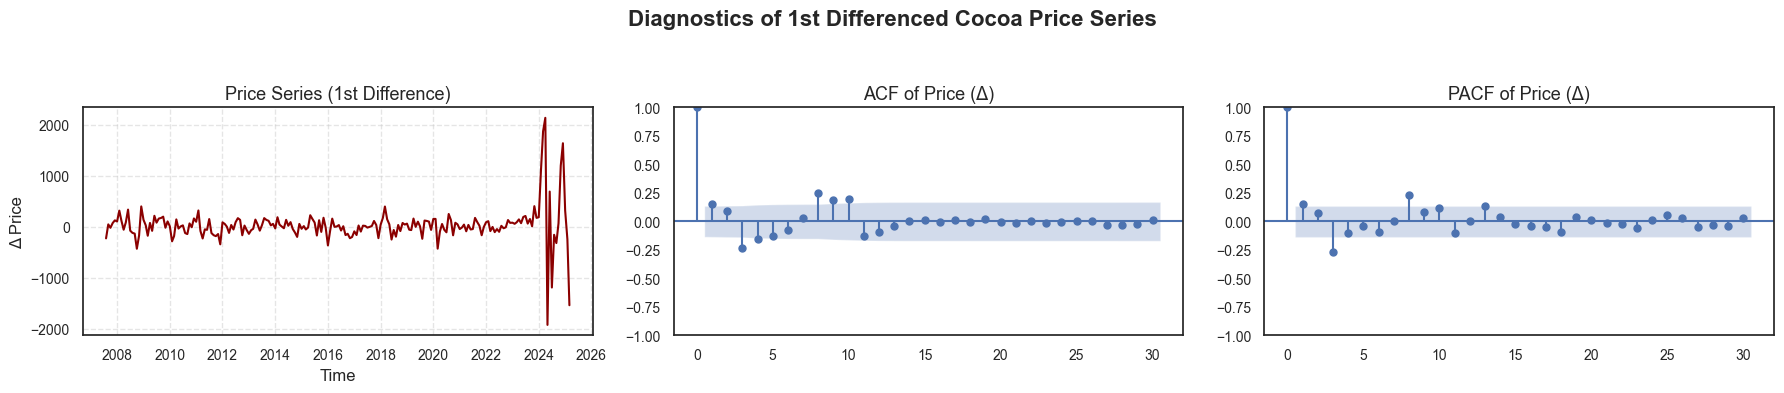

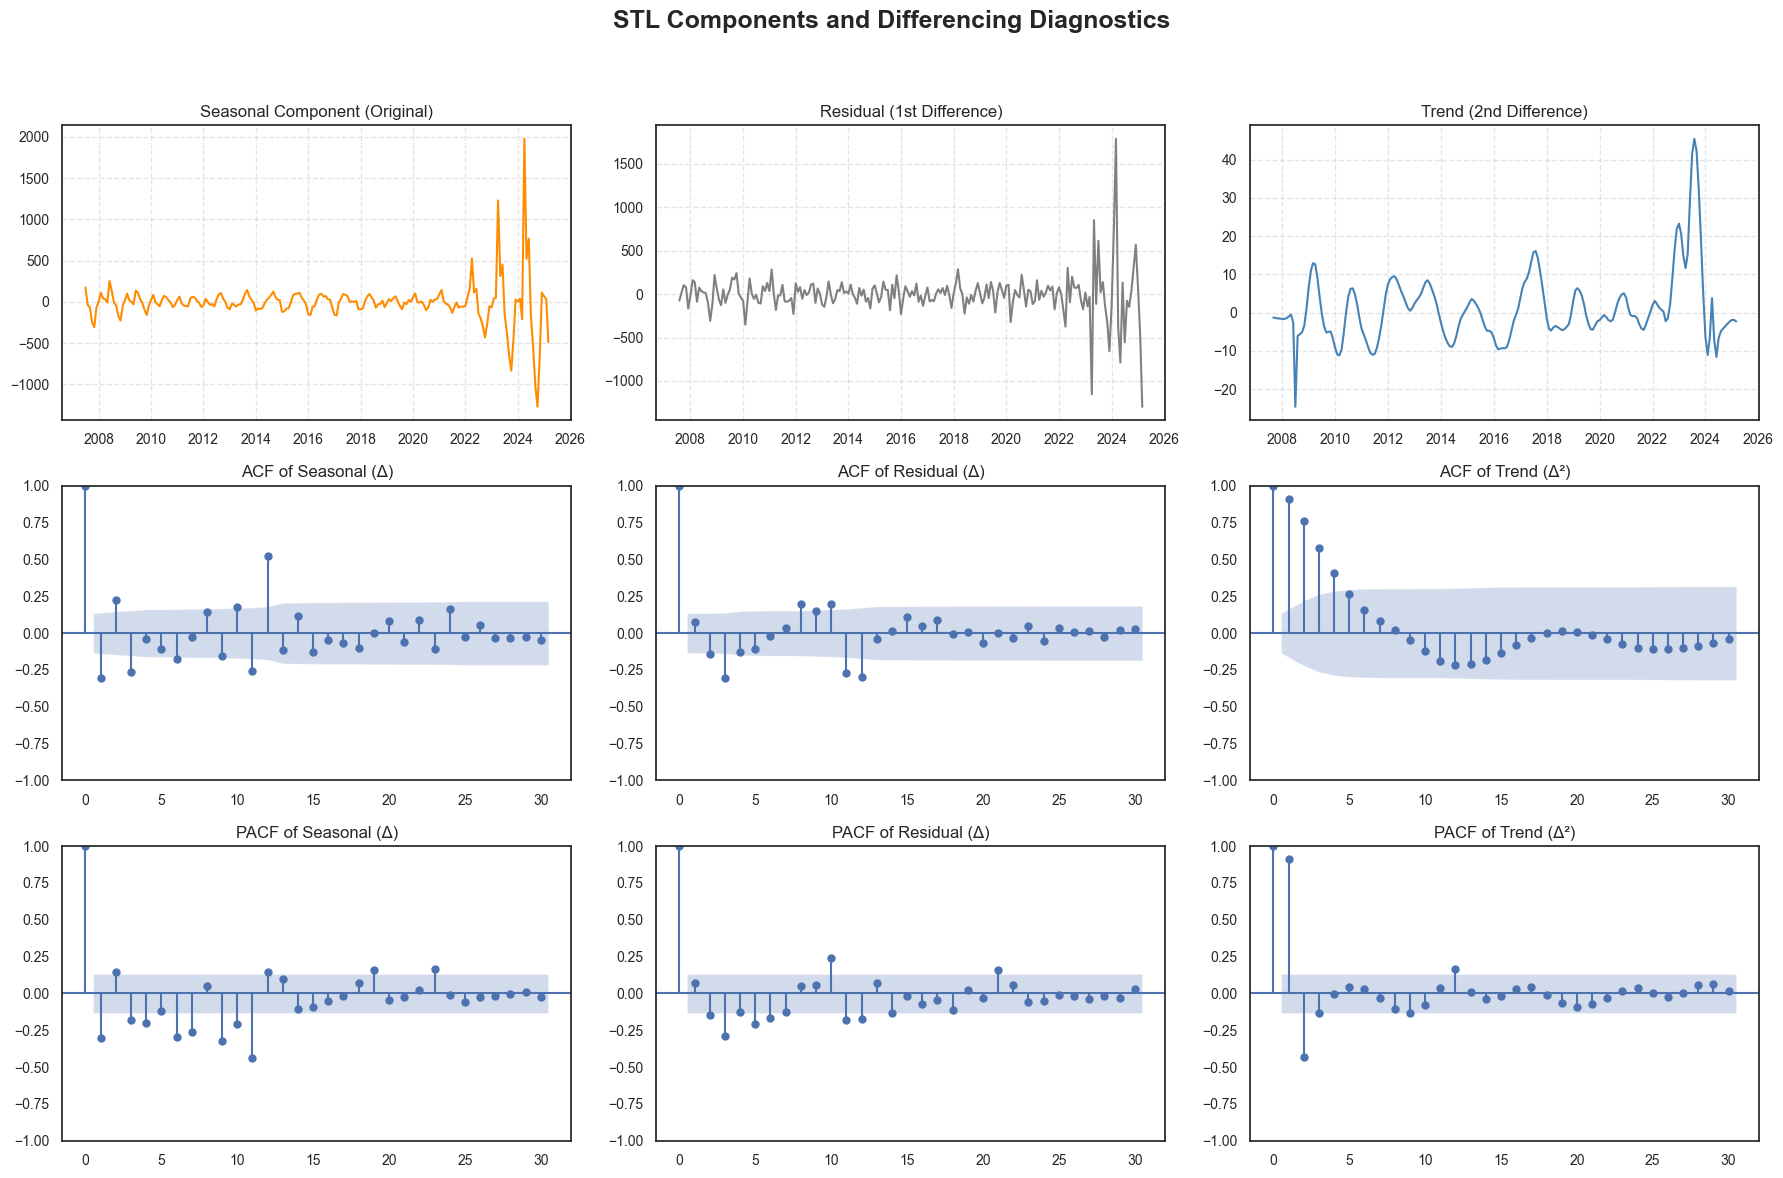

In [29]:
price_diff1 = price_series.diff().dropna()

# === Create 1x3 Figure Panel ===
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle("Diagnostics of 1st Differenced Cocoa Price Series", fontsize=16, weight="bold")

# --- 1. 差分时序图 ---
axes[0].plot(price_diff1, color="darkred")
axes[0].set_title("Price Series (1st Difference)", fontsize=13)
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Δ Price")
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- 2. ACF ---
plot_acf(price_diff1, lags=30, ax=axes[1])
axes[1].set_title("ACF of Price (Δ)", fontsize=13)

# --- 3. PACF ---
plot_pacf(price_diff1, lags=30, ax=axes[2], method="ywm")
axes[2].set_title("PACF of Price (Δ)", fontsize=13)

# --- 美化 ---
for ax in axes:
    ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

trend_diff2 = trend.diff().diff().dropna()

resid_diff = resid.diff().dropna()

seasonal_orig = seasonal

seasonal_diff = seasonal.diff().dropna()

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("STL Components and Differencing Diagnostics", fontsize=18, weight="bold")

axes[0, 0].plot(seasonal_orig, color="darkorange")
axes[0, 0].set_title("Seasonal Component (Original)")
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

axes[0, 1].plot(resid_diff, color="gray")
axes[0, 1].set_title("Residual (1st Difference)")
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

axes[0, 2].plot(trend_diff2, color="steelblue")
axes[0, 2].set_title("Trend (2nd Difference)")
axes[0, 2].grid(True, linestyle="--", alpha=0.5)

plot_acf(seasonal_diff.dropna(), ax=axes[1, 0], lags=30)
axes[1, 0].set_title("ACF of Seasonal (Δ)")

plot_acf(resid_diff.dropna(), ax=axes[1, 1], lags=30)
axes[1, 1].set_title("ACF of Residual (Δ)")

plot_acf(trend_diff2.dropna(), ax=axes[1, 2], lags=30)
axes[1, 2].set_title("ACF of Trend (Δ²)")

plot_pacf(seasonal_diff.dropna(), ax=axes[2, 0], lags=30, method="ywm")
axes[2, 0].set_title("PACF of Seasonal (Δ)")

plot_pacf(resid_diff.dropna(), ax=axes[2, 1], lags=30, method="ywm")
axes[2, 1].set_title("PACF of Residual (Δ)")

plot_pacf(trend_diff2.dropna(), ax=axes[2, 2], lags=30, method="ywm")
axes[2, 2].set_title("PACF of Trend (Δ²)")

for ax in axes.flatten():
    ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

In [32]:
# ---- Rolling Forward Prediction with Recording of Fitted Values ----
monthly_data_ts = monthly_data.set_index("Month")
price_series = monthly_data_ts["Price_NY"]

stl = STL(price_series, period=12)
res = stl.fit()

trend = res.trend.dropna()
seasonal = res.seasonal.dropna()
resid = res.resid.dropna()

common_index = trend.index.intersection(seasonal.index).intersection(resid.index)

trend = trend.loc[common_index]
seasonal = seasonal.loc[common_index]
resid = resid.loc[common_index]

n = len(trend)
train_size = int(n * 0.95)

trend_train, trend_test = trend[:train_size], trend[train_size:]
seasonal_train, seasonal_test = seasonal[:train_size], seasonal[train_size:]
resid_train, resid_test = resid[:train_size], resid[train_size:]

# Lists to store one-step forecasts and fitted values for each component
trend_forecasts = []
seasonal_forecasts = []
resid_forecasts = []

trend_fitted_rolling = []
seasonal_fitted_rolling = []
resid_fitted_rolling = []

# List to store the corresponding indices for the last training observations
training_last_idx_list = []

# For constructing confidence intervals (for final combined forecast)
combined_forecasts = []
ci_upper_rolling = []
ci_lower_rolling = []
z = 1.96  # 95% confidence level

# Use the test set index (forecast_index) for the rolling forecast
forecast_index = trend_test.index

for current_time in forecast_index:
    trend_train_current = trend.loc[:current_time].iloc[:-1]
    seasonal_train_current = seasonal.loc[:current_time].iloc[:-1]
    resid_train_current = resid.loc[:current_time].iloc[:-1]
    
    last_training_idx = trend_train_current.index[-1]
    training_last_idx_list.append(last_training_idx)
    
    trend_model = ARIMA(trend_train_current, order=(2, 2, 5)).fit()
    seasonal_model = SARIMAX(seasonal_train_current, 
                             order=(4, 0, 4), 
                             seasonal_order=(1, 0, 1, 12)).fit()
    resid_model = ARIMA(resid_train_current, order=(1, 1, 1)).fit()
    
    trend_fitted = trend_model.fittedvalues.iloc[-1]
    seasonal_fitted = seasonal_model.fittedvalues.iloc[-1]
    resid_fitted = resid_model.fittedvalues.iloc[-1]
    
    trend_fitted_rolling.append(trend_fitted)
    seasonal_fitted_rolling.append(seasonal_fitted)
    resid_fitted_rolling.append(resid_fitted)

    trend_fc = trend_model.forecast(steps=1)
    seasonal_fc = seasonal_model.forecast(steps=1)
    resid_fc = resid_model.forecast(steps=1)
    
    trend_forecasts.append(trend_fc.iloc[0])
    seasonal_forecasts.append(seasonal_fc.iloc[0])
    resid_forecasts.append(resid_fc.iloc[0])

    forecast_value = trend_fc.iloc[0] + seasonal_fc.iloc[0] + resid_fc.iloc[0]
    combined_forecasts.append(forecast_value)
    
    resid_std_current = resid_train_current.std()
    ci_upper_rolling.append(forecast_value + z * resid_std_current)
    ci_lower_rolling.append(forecast_value - z * resid_std_current)

reconstructed_forecast_rolling = pd.Series(combined_forecasts, index=forecast_index)
ci_upper_series = pd.Series(ci_upper_rolling, index=forecast_index)
ci_lower_series = pd.Series(ci_lower_rolling, index=forecast_index)

trend_forecasts_series = pd.Series(trend_forecasts, index=forecast_index)
seasonal_forecasts_series = pd.Series(seasonal_forecasts, index=forecast_index)
resid_forecasts_series = pd.Series(resid_forecasts, index=forecast_index)

trend_fitted_series = pd.Series(trend_fitted_rolling, index=training_last_idx_list)
seasonal_fitted_series = pd.Series(seasonal_fitted_rolling, index=training_last_idx_list)
resid_fitted_series = pd.Series(resid_fitted_rolling, index=training_last_idx_list)

fig, axes = plt.subplots(4, 1, figsize=(18, 12))

true_price_rolling = price_series.loc[forecast_index]
rmse = np.sqrt(root_mean_squared_error(true_price_rolling, reconstructed_forecast_rolling))
mae = mean_absolute_error(true_price_rolling, reconstructed_forecast_rolling)
mape = mean_absolute_percentage_error(true_price_rolling, reconstructed_forecast_rolling) * 100
eval_text = f"Rolling Forecast RMSE: {rmse:.2f}   MAE: {mae:.2f}   MAPE: {mape:.2f}%"

# 1. Trend Component
axes[0].plot(trend.index, trend, label="Actual Trend", color="black", linewidth=1.5)
axes[0].plot(trend_fitted_series.index, trend_fitted_series, 
             label="Rolling Fitted Trend", marker="o", linestyle="--", color="orange")
axes[0].plot(trend_forecasts_series.index, trend_forecasts_series, 
             label="Rolling Forecast Trend", marker="s", linestyle="--", color="green")
axes[0].set_title("Trend Component: Actual vs. Rolling Fitted & Forecast", fontsize=14)
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Trend")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# 2. Seasonal Component
axes[1].plot(seasonal.index, seasonal, label="Actual Seasonal", color="black", linewidth=1.5)
axes[1].plot(seasonal_fitted_series.index, seasonal_fitted_series, 
             label="Rolling Fitted Seasonal", marker="o", linestyle="--", color="orange")
axes[1].plot(seasonal_forecasts_series.index, seasonal_forecasts_series, 
             label="Rolling Forecast Seasonal", marker="s", linestyle="--", color="green")
axes[1].set_title("Seasonal Component: Actual vs. Rolling Fitted & Forecast", fontsize=14)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Seasonal")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

# 3. Residual Component
axes[2].plot(resid.index, resid, label="Actual Residual", color="black", linewidth=1.5)
axes[2].plot(resid_fitted_series.index, resid_fitted_series, 
             label="Rolling Fitted Residual", marker="o", linestyle="--", color="orange")
axes[2].plot(forecast_index, resid_forecasts_series, 
             label="Rolling Forecast Residual", marker="s", linestyle="--", color="green")
axes[2].set_title("Residual Component: Actual vs. Rolling Fitted & Forecast", fontsize=14)
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Residual")
axes[2].legend()
axes[2].grid(True, linestyle="--", alpha=0.5)

axes[3].plot(price_series, label="Actual Price", color="black", linewidth=1.5)
axes[3].plot(forecast_index, reconstructed_forecast_rolling, 
        label="STL-ARIMA Rolling Forecast", color="green", linewidth=2)
axes[3].plot(true_price_rolling, label="Test Actual", color="blue", linestyle="dotted")
axes[3].fill_between(forecast_index, ci_lower_series, ci_upper_series, 
                color="lightgreen", alpha=0.3, label="95% CI")
axes[3].set_xlabel("Time")
axes[3].set_ylabel("Cocoa Price (USD/ton)")
axes[3].legend()
axes[3].grid(True, linestyle="--", alpha=0.5)

fig.suptitle("STL Decompose-ARIMA Single-Step Rolling Forecast with 95% Confidence Interval\n" + eval_text, fontsize=16, weight="bold", y=1.02)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()


/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ciara/Desktop/Final Project/.venv

LinAlgError: LU decomposition error.

In [33]:
def plot_ljung_box(model_results, model_name="SARIMA"):
    standardized_resid = model_results.filter_results.standardized_forecasts_error[0]
    standardized_resid = standardized_resid[~np.isnan(standardized_resid)]
    ljung_box = acorr_ljungbox(standardized_resid, lags=20, return_df=True)

    plt.figure(figsize=(12, 3))
    plt.scatter(ljung_box.index, ljung_box['lb_pvalue'], facecolors='none', edgecolors='black', s=40)
    plt.axhline(y=0.05, color='blue', linestyle='--', linewidth=1, label='0.05 threshold')
    plt.title(f"{model_name} - Ljung-Box Test p-values", fontsize=12)
    plt.xlabel("Lag")
    plt.ylabel("p-value")
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()


/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ciara/Desktop/Final Project/.venv/lib/pyth

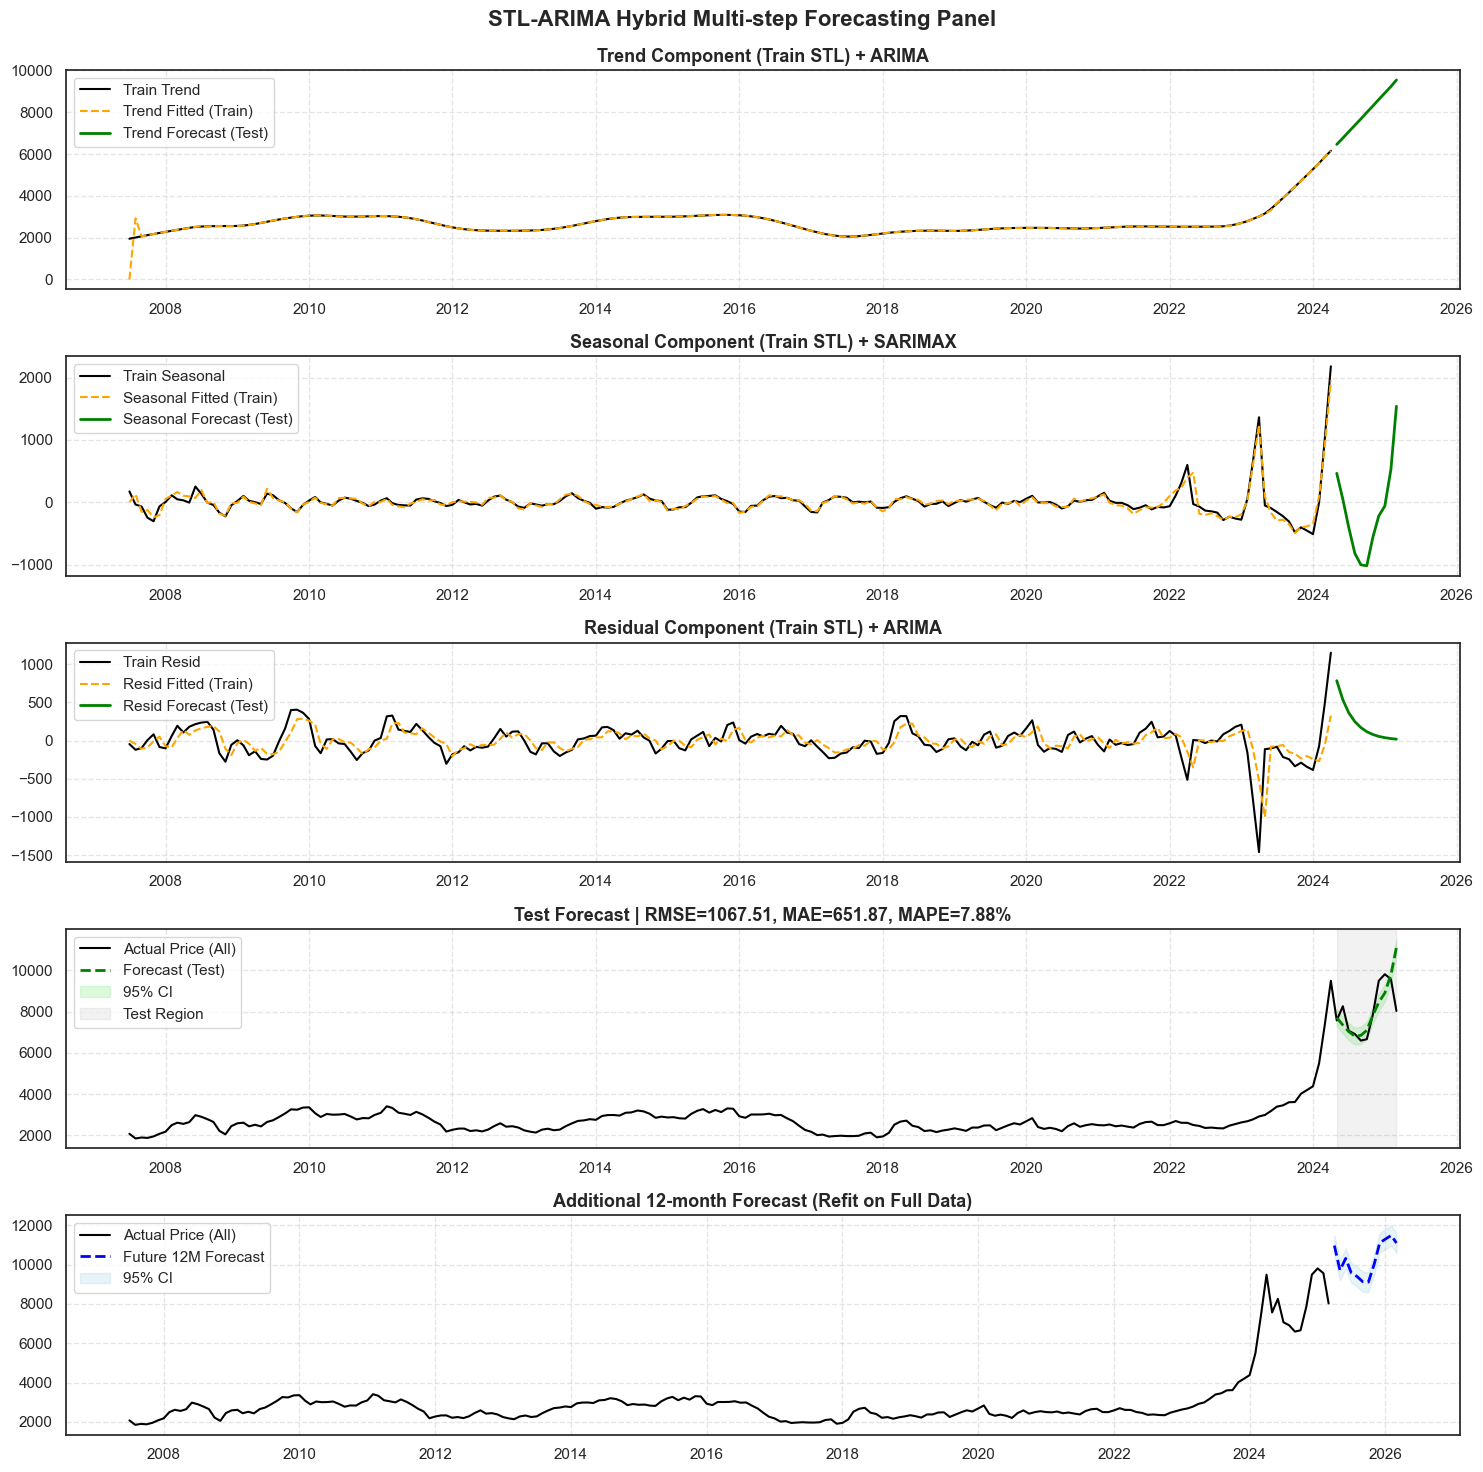

In [34]:
monthly_data_ts = monthly_data.set_index("Month")
price_series = monthly_data_ts["Price_NY"]

n = len(price_series)
train_size = int(n * 0.95)
train_series = price_series.iloc[:train_size]
test_series = price_series.iloc[train_size:]

stl = STL(train_series, period=12).fit()
train_trend = stl.trend
train_seasonal = stl.seasonal
train_resid = stl.resid

trend_model = ARIMA(train_trend, order=(2,2,5)).fit()
seasonal_model = SARIMAX(train_seasonal, order=(5,0,4), seasonal_order=(1,0,1,12)).fit()
resid_model = ARIMA(train_resid, order=(1,1,1)).fit()

h = len(test_series)
trend_forecast = trend_model.forecast(steps=h)
seasonal_forecast = seasonal_model.forecast(steps=h)
resid_forecast = resid_model.forecast(steps=h)

final_forecast_test = trend_forecast + seasonal_forecast + resid_forecast

z = 1.96
resid_std = train_resid.std()
ci_upper_test = final_forecast_test + z * resid_std
ci_lower_test = final_forecast_test - z * resid_std

test_index = test_series.index
true_price_test = price_series.loc[test_index]

rmse = root_mean_squared_error(true_price_test, final_forecast_test)
mae = mean_absolute_error(true_price_test, final_forecast_test)
mape = mean_absolute_percentage_error(true_price_test, final_forecast_test) * 100
eval_text = f"Test Forecast | RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%"

full_stl = STL(price_series, period=12).fit()
full_trend = full_stl.trend
full_seasonal = full_stl.seasonal
full_resid = full_stl.resid

full_trend_model = ARIMA(full_trend, order=(2,2,5)).fit()
full_seasonal_model = SARIMAX(full_seasonal, order=(5,0,4), seasonal_order=(1,0,1,12)).fit()
full_resid_model = ARIMA(full_resid, order=(1,1,1)).fit()

future_steps = 12
trend_future_fc = full_trend_model.forecast(steps=future_steps)
seasonal_future_fc = full_seasonal_model.forecast(steps=future_steps)
resid_future_fc = full_resid_model.forecast(steps=future_steps)

final_future_fc = trend_future_fc + seasonal_future_fc + resid_future_fc

last_date = price_series.index[-1]
future_index = pd.date_range(last_date + pd.DateOffset(months=1),
                            periods=future_steps, freq='MS')
final_future_fc.index = future_index

full_resid_std = full_resid.std()
ci_upper_12 = final_future_fc + z * full_resid_std
ci_lower_12 = final_future_fc - z * full_resid_std
ci_upper_12.index = future_index
ci_lower_12.index = future_index

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].plot(train_trend, label="Train Trend", color="black", linewidth=1.5)
axes[0].plot(trend_model.fittedvalues, label="Trend Fitted (Train)", 
             color="orange", linestyle="--", linewidth=1.5)
axes[0].plot(trend_forecast.index, trend_forecast, label="Trend Forecast (Test)",
             color="green", linewidth=2)
axes[0].set_title("Trend Component (Train STL) + ARIMA", fontsize=13, weight="bold")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

axes[1].plot(train_seasonal, label="Train Seasonal", color="black", linewidth=1.5)
axes[1].plot(seasonal_model.fittedvalues, label="Seasonal Fitted (Train)",
             color="orange", linestyle="--", linewidth=1.5)
axes[1].plot(seasonal_forecast.index, seasonal_forecast, label="Seasonal Forecast (Test)",
             color="green", linewidth=2)
axes[1].set_title("Seasonal Component (Train STL) + SARIMAX", fontsize=13, weight="bold")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

axes[2].plot(train_resid, label="Train Resid", color="black", linewidth=1.5)
axes[2].plot(resid_model.fittedvalues, label="Resid Fitted (Train)",
             color="orange", linestyle="--", linewidth=1.5)
axes[2].plot(resid_forecast.index, resid_forecast, label="Resid Forecast (Test)",
             color="green", linewidth=2)
axes[2].set_title("Residual Component (Train STL) + ARIMA", fontsize=13, weight="bold")
axes[2].legend()
axes[2].grid(True, linestyle="--", alpha=0.5)

axes[3].plot(price_series, label="Actual Price (All)", color="black", linewidth=1.5)
axes[3].plot(final_forecast_test.index, final_forecast_test, label="Forecast (Test)",
             color="green", linewidth=2, linestyle="--")
axes[3].fill_between(final_forecast_test.index, ci_lower_test, ci_upper_test,
                     color="lightgreen", alpha=0.3, label="95% CI")
axes[3].axvspan(test_index[0], test_index[-1], color="grey", alpha=0.1, label="Test Region")
axes[3].set_title(eval_text, fontsize=13, weight="bold")
axes[3].legend()
axes[3].grid(True, linestyle="--", alpha=0.5)

axes[4].plot(price_series, label="Actual Price (All)", color="black", linewidth=1.5)
axes[4].plot(final_future_fc.index, final_future_fc, label="Future 12M Forecast",
             color="blue", linewidth=2, linestyle="--")
axes[4].fill_between(final_future_fc.index, ci_lower_12, ci_upper_12,
                     color="lightblue", alpha=0.3, label="95% CI")

axes[4].set_title("Additional 12-month Forecast (Refit on Full Data)", fontsize=13, weight="bold")
axes[4].legend()
axes[4].grid(True, linestyle="--", alpha=0.5)

fig.suptitle("STL-ARIMA Hybrid Multi-step Forecasting Panel",
             fontsize=16, weight="bold")

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()


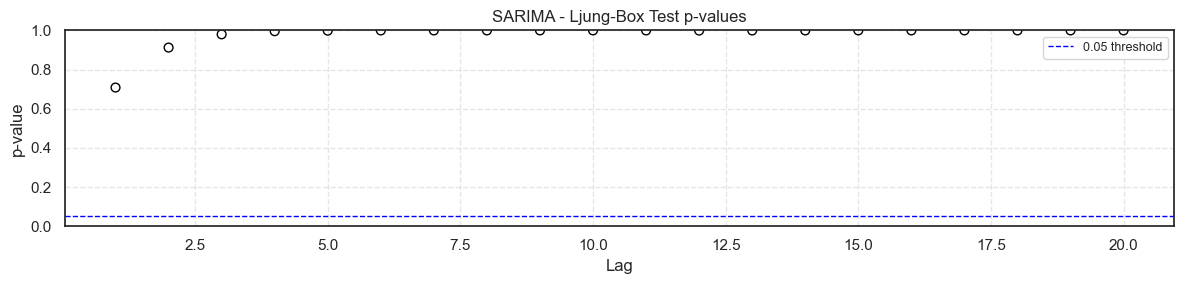

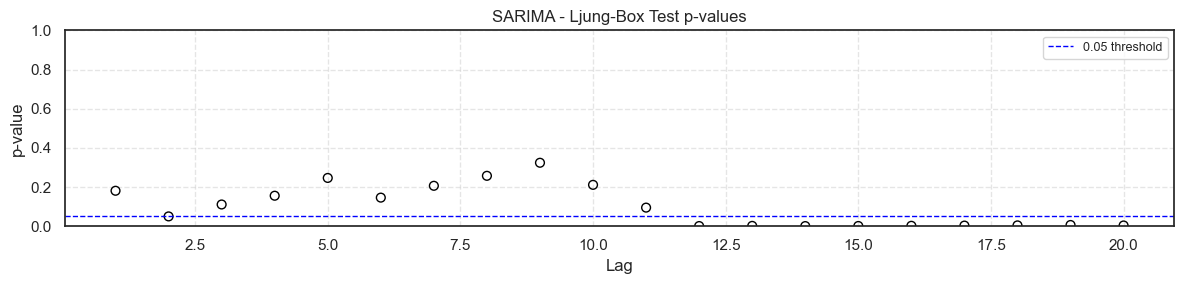

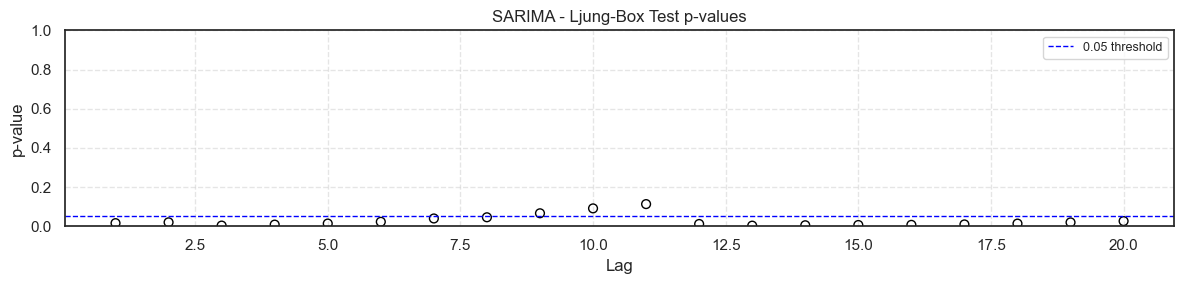

In [35]:
plot_ljung_box(trend_model)
plot_ljung_box(seasonal_model)
plot_ljung_box(resid_model)

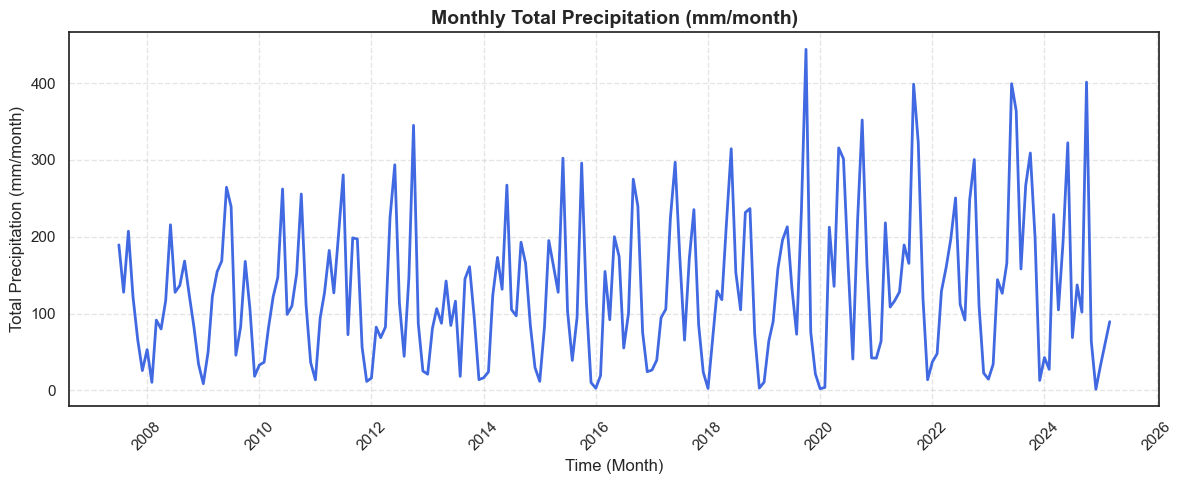

In [36]:
monthly_data["Total_Precip_mm"] = monthly_data["PRECTOTCORR"] * monthly_data["Month"].dt.days_in_month

plt.figure(figsize=(12, 5))
plt.plot(monthly_data["Month"], monthly_data["Total_Precip_mm"], color="royalblue", linewidth=2)

plt.title("Monthly Total Precipitation (mm/month)", fontsize=14, weight="bold")
plt.xlabel("Time (Month)", fontsize=12)
plt.ylabel("Total Precipitation (mm/month)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_data["Year"] = monthly_data["Month"].dt.year


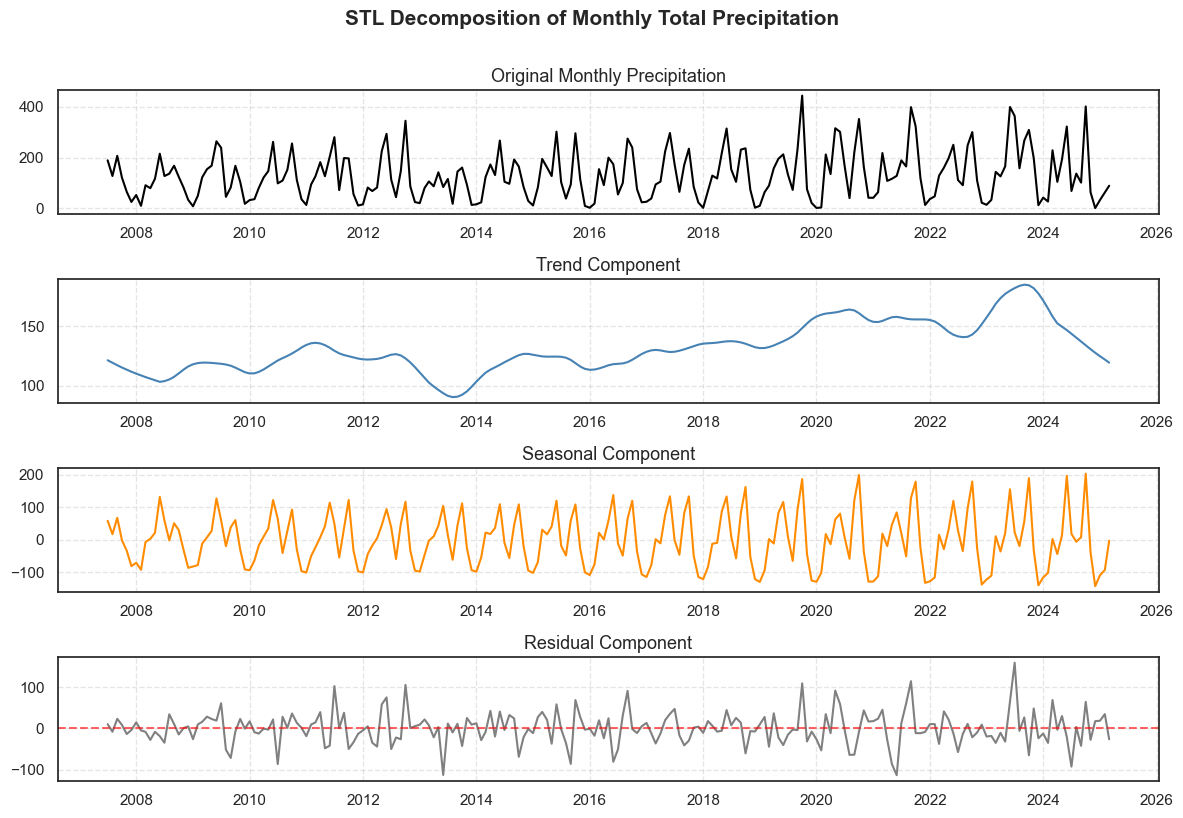

In [86]:
monthly_data_ts = monthly_data.set_index("Month")
precip_series = monthly_data_ts["Total_Precip_mm"].dropna()

stl = STL(precip_series, period=12)
res = stl.fit()

trend = res.trend
seasonal = res.seasonal
resid = res.resid

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(precip_series, color="black")
plt.title("Original Monthly Precipitation", fontsize=13)
plt.grid(True, linestyle="--", alpha=0.5)

plt.subplot(4, 1, 2)
plt.plot(trend, color="steelblue")
plt.title("Trend Component", fontsize=13)
plt.grid(True, linestyle="--", alpha=0.5)

plt.subplot(4, 1, 3)
plt.plot(seasonal, color="darkorange")
plt.title("Seasonal Component", fontsize=13)
plt.grid(True, linestyle="--", alpha=0.5)

plt.subplot(4, 1, 4)
plt.plot(resid, color="gray")
plt.axhline(0, color="red", linestyle="--", alpha=0.6)
plt.title("Residual Component", fontsize=13)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.suptitle("STL Decomposition of Monthly Total Precipitation", fontsize=15, weight="bold", y=1.02)
plt.subplots_adjust(top=0.92)
plt.show()

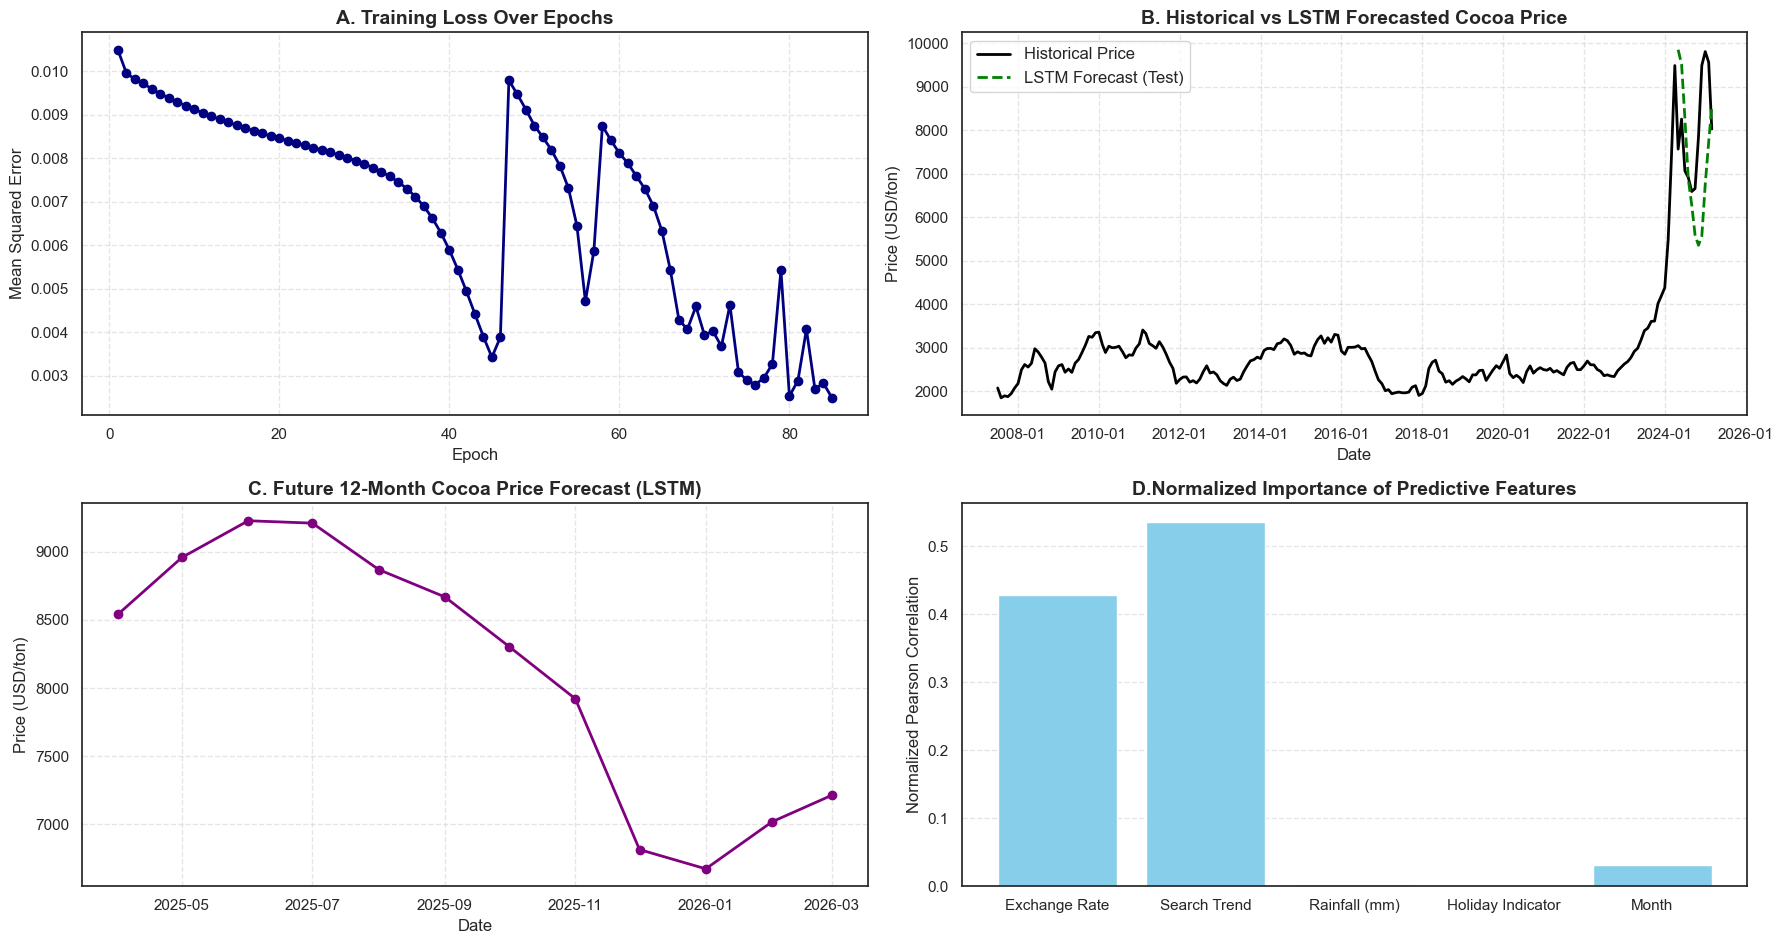

In [98]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

SEED = 457
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Replace these with your actual final feature names
feat_names = ['Exchange Rate', 'Search Trend', 'Rainfall (mm)', 'Holiday Indicator', 'Month']
feat_vals = [feature_importance[k] for k in feature_importance]

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Plot 1: Training Loss
axes[0, 0].plot(range(1, len(train_losses)+1), train_losses, marker="o", color="navy", linewidth=2)
axes[0, 0].set_title("A. Training Loss Over Epochs", fontsize=14, weight="bold")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Mean Squared Error")
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

# Plot 2: Test Forecast vs Actual
# axes[0, 1].plot(dates_test, actual_test_inv, label="Actual Price", color="black", linewidth=2)
# axes[0, 1].plot(dates_test, preds_test_inv, label="Predicted Price (LSTM)", color="green", linestyle="--", linewidth=2)
# axes[0, 1].set_title("LSTM Forecast vs Actual Cocoa Price", fontsize=14, weight="bold")
# axes[0, 1].set_xlabel("Date")
# axes[0, 1].set_ylabel("Price (USD/ton)")
# axes[0, 1].legend(fontsize=12)
# axes[0, 1].grid(True, linestyle="--", alpha=0.5)
# axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# axes[0, 1].xaxis.set_major_locator(mdates.AutoDateLocator())

# Plot 3: Full Price History + Test Forecast
axes[0, 1].plot(monthly_data["Month"], monthly_data["Price_NY"], label="Historical Price", color="black", linewidth=2)
axes[0, 1].plot(dates_test, preds_test_inv, label="LSTM Forecast (Test)", color="green", linestyle="--", linewidth=2)
axes[0, 1].set_title("B. Historical vs LSTM Forecasted Cocoa Price", fontsize=14, weight="bold")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Price (USD/ton)")
axes[0, 1].legend(fontsize=12)
axes[0, 1].grid(True, linestyle="--", alpha=0.5)
axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0, 1].xaxis.set_major_locator(mdates.AutoDateLocator())

# Plot 4: Future Forecast
axes[1, 0].plot(future_dates, future_preds_inv, marker="o", color="purple", linewidth=2)
axes[1, 0].set_title("C. Future 12-Month Cocoa Price Forecast (LSTM)", fontsize=14, weight="bold")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Price (USD/ton)")
axes[1, 0].grid(True, linestyle="--", alpha=0.5)
axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[1, 0].xaxis.set_major_locator(mdates.AutoDateLocator())

# Plot 5: Feature Importance
axes[1, 1].bar(feat_names, feat_vals, color="skyblue")
axes[1, 1].set_title("D.Normalized Importance of Predictive Features", fontsize=14, weight="bold")
axes[1, 1].set_ylabel("Normalized Pearson Correlation")
axes[1, 1].grid(axis="y", linestyle="--", alpha=0.5)

# # Plot 6: Summary Text
# axes[2, 1].axis('off')
# summary_text = (
#     f"Test Set Evaluation:\n"
#     f"- RMSE: {rmse:.2f} USD/ton\n"
#     f"- MAE : {mae:.2f} USD/ton\n"
#     f"- MAPE: {mape:.2f}%\n\n"
#     f"Training Details:\n"
#     f"- Epochs: {epochs}\n"
#     f"- Batch Size: 16\n"
#     f"- Optimizer: Adam (lr=0.0005)\n"
#     f"- Loss Function: Mean Squared Error\n\n"
#     f"Future Forecast:\n"
#     f"- 12-month forecast from last known point\n"
#     f"- Assumes other variables stay constant."
# )
# axes[2, 1].text(0.05, 0.5, summary_text, fontsize=13, verticalalignment='center')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()